X-Ray 이미지 - 전자기파가 몸을 통과한 결과
폐렴 - 폐에 염증이 생긴 것
폐 - 공기를 통해 호흡 작용을 하는 기관
염증 - 우리 몸에 침투한 세균과 싸우기 위해 백혈구들이 싸우고 있는 곳

# I. 폐렴을 진단해보자(1)
using 이미지 처리에 특화된 모델인 CNN

## 1. Set-up
### (1) 이번 프로젝트에서 사용할 패키지(라이브러리) import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### (2) 앞으로 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train, test, val 데이터 갯수
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


-----프린트 결과----- 
개수 비는 89%, 10.7%, 0.3%로 val 개수가 너무 없다 
-> train에서 val에 쓰일 데이터를 가져오자. 
how?
train과 val에 있는 데이터를 모은다 
-> train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 이제, train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한 번 보자.
print(f'Normal image path\n{filenames[0]}')    # 정상 이미지 - 파일 경로에 NORMAL
print(f'Pneumonia image path\n{filenames[2000]}')    # 폐렴 이미지 - 파일 경로에 PNEUMONIA

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
# 정상 이미지, 폐렴 이미지 데이터 갯수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


-----프린트 결과----- 
폐렴 이미지 수가 3배 더 많음 
-> CNN 모델은 데이터가 클래스 별 balance가 좋을수록 training을 잘함. 
/ 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정. 
단, test와 val 데이터셋은 imbalance한 데이터 셋이어도 문제가 없다. 평가하려고 쓰는 것이므로 학습과 관련이 없기 때문이다.

In [7]:
# tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)    # tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있게 해줌
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

## 3-1. train과 validation 데이터셋 전처리

In [8]:
# train 데이터셋, val 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### (1) 이미지에 라벨 데이터를 만들어주는 함수 만들기 : 파일 경로에 포함되어있는 'NORMAL'이나 'PNEUMONIA'를 이용

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### (2) 이미지 사이즈 통일 -> GPU 메모리를 더욱 효율적으로 사용
* 현실적으로, 이미지 데이터는 사이즈가 제각각일 가능성이 높기 때문
* i. process_path 함수에서 
* decode_img 함수를 이용해서
* 이미지의 데이터 타입을 float으로 바꾸고
* 사이즈를 변경
* get_label을 이용해서 라벨 값을 가져 온다

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터셋과 validation 데이터셋 만들기 
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# 이때, num_parallel_calls 파라미터에 위에서 할당한 autotune변수를 이용하면 더욱 빠르게 데이터를 처리할 수 있음.

In [12]:
# 이미지 크기 확인, 라벨 확인
for image, label in train_ds.take(1):    # "하나의 데이터만 가져와" - train_ds.take(1) 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


## 3-2. test 데이터셋 전처리

In [13]:
# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 갯수 확인
print(TEST_IMAGE_COUNT) 

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
'''
# Tensorflow의 tf.data 파이프라인 - 학습 데이터를 효율적으로 사용할 수 있도록 해줌
# 데이터 변환 - tf.data 파이프라인을 이용해서 prepare_for_training() 함수를 정의해서
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)    
    # shuffle() - 고정 크기 버퍼?를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat()    
    # repeat() - epoch을 진행하면서 여러 번 데이터셋을 불러옴. 이때 repeat()을 사용한 데이터의 경우 여러 번 데이터셋을 사용할 수 있게 해줌
    # ex. 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요. repeat()를 사용하면 자동으로 데이터를 맞춰줌
    ds = ds.batch(BATCH_SIZE)
    # batch() - BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    # ex. 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됨
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    # prefetch() - 학습 데이터를 나눠서 읽어옴 -> 리소스의 유휴 상태를 줄일 수 있음
    # 왜? 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
'''

'\n# Tensorflow의 tf.data 파이프라인 - 학습 데이터를 효율적으로 사용할 수 있도록 해줌\n# 데이터 변환 - tf.data 파이프라인을 이용해서 prepare_for_training() 함수를 정의해서\ndef prepare_for_training(ds, shuffle_buffer_size=1000):\n    ds = ds.shuffle(buffer_size=shuffle_buffer_size)    \n    # shuffle() - 고정 크기 버퍼?를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택\n    ds = ds.repeat()    \n    # repeat() - epoch을 진행하면서 여러 번 데이터셋을 불러옴. 이때 repeat()을 사용한 데이터의 경우 여러 번 데이터셋을 사용할 수 있게 해줌\n    # ex. 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요. repeat()를 사용하면 자동으로 데이터를 맞춰줌\n    ds = ds.batch(BATCH_SIZE)\n    # batch() - BATCH_SIZE에서 정한 만큼의 배치로 주어짐\n    # ex. 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됨\n    ds = ds.prefetch(buffer_size=AUTOTUNE)\n    # prefetch() - 학습 데이터를 나눠서 읽어옴 -> 리소스의 유휴 상태를 줄일 수 있음\n    # 왜? 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있음\n    return ds\n\ntrain_ds = prepare_for_training(train_ds)\nval_ds = prepare_for_training(val_ds)\n'

## 4. 데이터 시각화
train에 있는 batch 중 
첫 번째 배치를 추출,
추출된 배치를 
image와 label 데이터 셋으로 나누는
show_batch() 함수

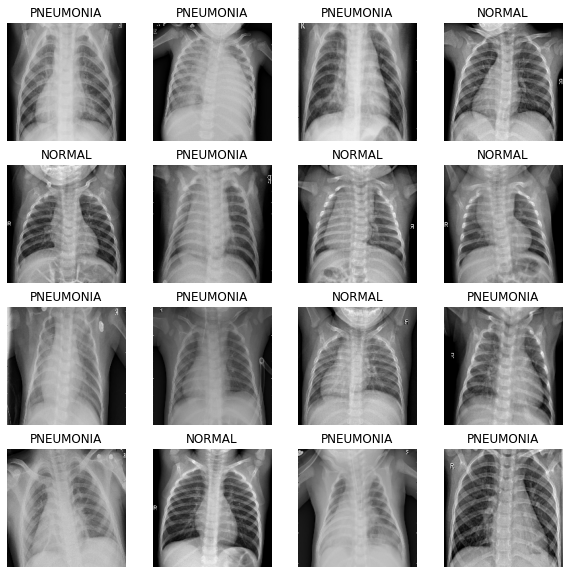

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# II. 폐렴을 진단해보자(2)
## 1. CNN 모델링

### (1) conv_block()의 구성
* Convolution[합성곱] 두 번 진행
* Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결 
* Max Pooling

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 2. 데이터 imbalance 처리
* Weight balancing - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [20]:
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0    #  weight_for_0은 'Normal' 이미지에 사용할 weight를 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0    # weight_for_1은 'Pneumonia' 이미지에 사용할 weight 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 3. 모델 훈련

In [21]:
with tf.device('/GPU:0'):    # GPU 선택 - 이미지 훈련은 GPU를 사용
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
'''
# 최고의 정확도를 가질때 멈춰주는 EarlyStopping() 함수 추가
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=5)
'''

"\n# 최고의 정확도를 가질때 멈춰주는 EarlyStopping() 함수 추가\nfrom keras.callbacks import EarlyStopping\nes = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=5)\n"

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS, # callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 189ms/step - loss: 0.4326 - accuracy: 0.7957 - precision: 0.9462 - recall: 0.7693 - val_loss: 0.5785 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2824 - accuracy: 0.8851 - precision: 0.9676 - recall: 0.8747 - val_loss: 1.1226 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2355 - accuracy: 0.9068 - precision: 0.9739 - recall: 0.8990 - val_loss: 0.1952 - val_accuracy: 0.9269 - val_precision: 1.0000 - val_recall: 0.9007
Epoch 4/25
261/261 [==============================] - 50s 194ms/step - loss: 0.1998 - accuracy: 0.9219 - precision: 0.9783 - recall: 0.9153 - val_loss: 1.2090 - val_accuracy: 0.6106 - val_precision: 1.0000 - val_recall: 0.4733
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1833 - accura

## 4. 결과 확인

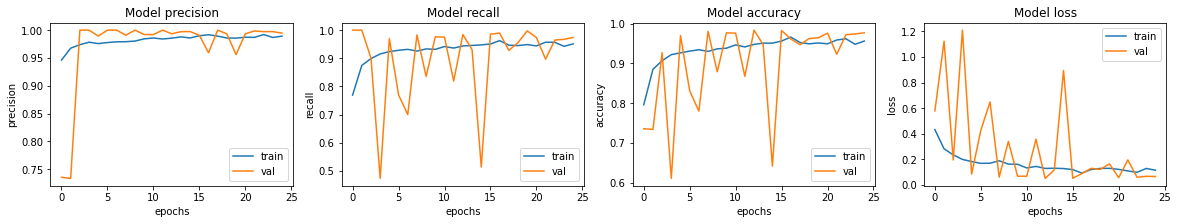

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 107ms/step - loss: 0.8579 - accuracy: 0.7901 - precision: 0.7534 - recall: 0.9872
Loss: 0.8578795194625854,
Accuracy: 0.7900640964508057,
Precision: 0.7534246444702148,
Recall: 0.9871794581413269


# 3. 폐렴 진단기 성능개선

## (1) 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. 
### : 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

모두가 train, validation 데이터 셋에 대하여 에포크가 늘어남에 따라 적절하게 증가 또는 감소함을 24번 셀에서 확인함.

## (2) 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. 
### : regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

좌우 반전 augumentation

+

i) regularization으로 Batch Normalization, Dropout 두 가지 기법을 사용하는 경우
=> Loss: 0.6711394786834717, Accuracy: 0.8333333134651184, Precision: 0.8487805128097534, Recall: 0.892307698726654
ii-1) BatchNormalization을 쓰지 않은 경우 
=> Loss : 0.694128, Accuracy : 0.375, Precision : 0.0, Recall : 0.0
=> Gradient vanishing 또는 Gradient Exploding 현상이 일어남
ii-2) Dropout을 쓰지 않은 경우 
=> Loss: 1.2532474994659424, Accuracy: 0.7868589758872986, Precision: 0.7495145797729492, Recall: 0.9897435903549194
ii-3) Dropout 비율을 변경하는 경우
 * dropout rate : 0.2*4 => Loss: 0.5966798067092896, Accuracy: 0.8157051205635071, Precision: 0.7811861038208008, Recall: 0.9794871807098389 
 * dropout rate : 0.2*2 => Loss: 0.8497419357299805, Accuracy: 0.7644230723381042, Precision: 0.7262569665908813, Recall: 1.0 
 * dropout rate : 0.05 => Loss: 0.8775213956832886, Accuracy: 0.7676281929016113, Precision: 0.7289719581604004, Recall: 1.0 
 * dropout rate : 0.3 => Loss: 0.8578795194625854, Accuracy: 0.7900640964508057, Precision: 0.7534246444702148, Recall: 0.9871794581413269
=> rate를 디폴트 값이었던 0.2보다 높이든 낮추든, Accuracy를 기준으로, 디폴트 값이었던 0.2때보다 대부분 좋지 않은 결과. 하지만 recall은 높은 수치를 기록함.

## (3) 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다. 
### : Accuracy 기준 85%에 도달하였다. => X

여러가지 시도를 해보았지만, recall은 높은 결과를 얻은 반면, accuracy를 디폴트 값보다 높일 수 없었음.
하이퍼 파라미터에 대해 보다 정확하고 심도깊은 이해가 필요하며, 그것을 바탕으로 한 체계적인 접근이 절실함을 느꼈음.


-----------여러가지 시도들-------------
시도(1) 좌우반전 augumentation + default 값의 하이퍼파라미터
* epoch = 25
Loss: 0.6711394786834717,
Accuracy: 0.8333333134651184,
Precision: 0.8487805128097534,
Recall: 0.892307698726654

시도(2) 
* batch_size *2
* epoch = 25*2 # 그래프에 나타난 트레이닝, 검증 세트 각각의 네 가지 평가지표별 점수를 종합하여 보았을 때, 30이 최적의 값이라 판단

시도(3) 
* epoch = 30
* 조기종료 추가 - 2번째 시도에서 그래프만으로는 30대 초반 에폭에서 점수가 높아지는 지표도 있고, 낮아지는 지표도 있어 정확하게는 판단하기 어려워 조기 종료기법을 사용하기로 함.
i. ModelCheckpoint 콜백
ii. EarlyStopping 콜백
--- 결과 ---
3에폭만에 조기종료가 되었다. Accuracy는 오히려 60%대로 떨어졌다.
train과 val 각각의 결과값이 4가지 지표 모두에서 상당히 큰 차이를 보인다.

시도(4)
* epoch = 30 
* 조기종료 제거
--- 결과 ---
Loss: 0.5807918310165405,
Accuracy: 0.807692289352417,
Precision: 0.79347825050354,
Recall: 0.9358974099159241

시도(5) 
epoch = 22
epoch =25 일때 그려본 손실그래프를 통해 epoch = 22일 때 더 나은 결과를 얻을 것으로 보여졌음.
--- 결과 ---
Loss: 0.6056436896324158,
Accuracy: 0.8413461446762085,
Precision: 0.8076109886169434,
Recall: 0.9794871807098389


시도(6)
최고의 정확도를 가질때 멈춰주는 EarlyStopping() 함수 추가, 매개변수로는 'accuracy'
-> EarlyStopping(monitor='accuracy',mode='max',verbose=1,patience=5)

Loss: 0.633659839630127,
Accuracy: 0.8044871687889099,
Precision: 0.772357702255249,
Recall: 0.9743589758872986

어라 성능이 되려 안좋네? 왜지?

시도(7)
잠깐 EarlyStopping을 제거하고....
이번 시도에서 궁금한 점 : 에폭22에서 같은 accuracy가 나오려나? 안나오지않을까? 랜덤으로 섞어서 훈련시킨다고 했는데... 시드를 정해주지 않은이상?

Loss: 0.9933366179466248,
Accuracy: 0.7724359035491943,
Precision: 0.7366412281990051,
Recall: 0.9897435903549194

그러네 일단 결과가 다르네..

시도(8)
다시 EarlyStopping 콜백 추가 그리고 매개변수로 'val_loss'를 사용
EPOCHS = 60

=> 조기종료 콜백을 추가했으므로 에포크는 많을수록 좋을 수 있지만, 시간상 60으로 주었다.

Loss: 0.7778608798980713,
Accuracy: 0.807692289352417,
Precision: 0.7732793688774109,
Recall: 0.9794871807098389

시도(9)
Epoch = 원상복귀
Regularization variation start! : i. batch normalization 안쓰기
--- 결과 ---
미쳐날뛰는 결과값 ;;;;
왜일까? 삭제한 batch normalization은 Gradient vanishing, Gradient Exploding을 해결한다고하니, 이런 현상이 일어났겠지?
Loss : 0.694128, Accuracy : 0.375, Precision : 0.0, Recall : 0.0

시도 (10)
batch normalization은 원상복구
dropout_rate을 기존의0.2에 4배로 줌.
--- 결과 ---
Loss: 0.5966798067092896,
Accuracy: 0.8157051205635071, -> 검증세트의 결과는 상당히 좋은데, 훈련세트의 결과는 디폴트 값이었던 0.2때보다 좋지 않았음
Precision: 0.7811861038208008,
Recall: 0.9794871807098389


시도 (11)
dropout_rate를 2배로 줄임
--- 결과 ---
Loss: 0.8497419357299805
Accuracy: 0.7644230723381042
Precision: 0.7262569665908813
Recall: 1.0 